In [128]:
import warnings
warnings.filterwarnings('ignore')
import os #directory navigation
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from skimage.io import imread 
import keras 
from keras import Sequential 
from tensorflow.keras.applications import MobileNetV2 
from keras.layers import Dense 
from keras.preprocessing import image 
import tensorflow as tf 
import tensorflow.keras.layers as layers 

In [101]:
# Reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

## Preliminary Data Analysis

In [102]:
brain_df = pd.read_csv('../input/brain-tumor/Brain Tumor.csv', usecols=[0,1])
brain_df.head()

,Image,Class
0,Image1,0
1,Image2,0
2,Image3,1
3,Image4,1
4,Image5,0


In [103]:
# Check for null variables
brain_df.isnull().sum()

Image    0
Class    0
dtype: int64

In [104]:
# Check for imbalance
brain_df['Class'].value_counts()

0    2079
1    1683
Name: Class, dtype: int64

<Axes: ylabel='count'>

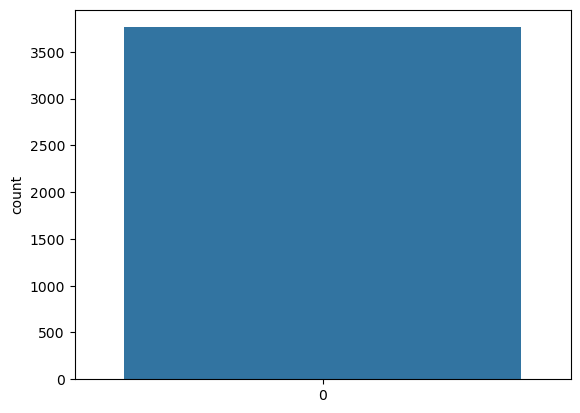

In [105]:
# Plot the value count
sns.countplot(brain_df['Class'])

In [106]:
# Get image paths to build a dictionary for data generators
path_list = []
base_path = '../input/brain-tumor/Brain Tumor/Brain Tumor'
for entry in os.listdir(base_path):
    path_list.append(os.path.join(base_path, entry))

In [107]:
# Create path dictionary and map it to brain_df['paths']
paths_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in path_list}
brain_df['Path'] = brain_df['Image'].map(paths_dict.get)
brain_df.head()

,Image,Class,Path
0,Image1,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...
1,Image2,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...
2,Image3,1,../input/brain-tumor/Brain Tumor/Brain Tumor/I...
3,Image4,1,../input/brain-tumor/Brain Tumor/Brain Tumor/I...
4,Image5,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...


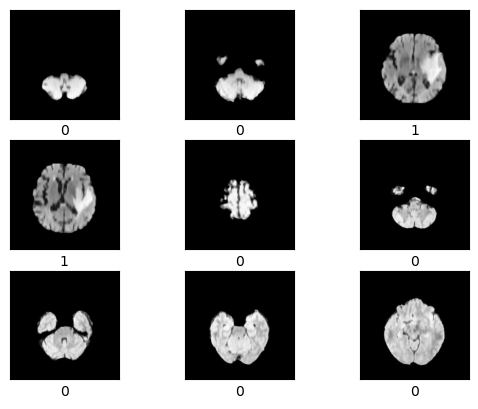

In [108]:
# Plot few samples
for x in range(0,9):
    plt.subplot(3,3,x+1)
    # Remove x and y axis scales
    plt.xticks([])
    plt.yticks([])
    img = imread(brain_df['Path'][x])
    plt.imshow(img)
    plt.xlabel(brain_df['Class'][x])

In [109]:
# Split brain_df into test and train lists for data generators
brain_df['split'] = np.random.randn(brain_df.shape[0], 1)

msk = np.random.rand(len(brain_df)) <= 0.8

train_df = brain_df[msk]
test_df = brain_df[~msk]
train_df.to_csv('brain_tumor_train.csv', index=False)
test_df.to_csv('brain_tumor_test.csv', index=False)
train_list = train_df.values.tolist()
test_list = test_df.values.tolist()

## Data Preprocessing

In [110]:
from random import shuffle
import cv2
def generator(samples, batch_size=32,shuffle_data=True):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                label = batch_sample[1]
                img_path = batch_sample[2]
                img =  cv2.imread(img_path)
                
                # apply any kind of preprocessing
                # img = cv2.resize(img,(resize,resize))
                img = img.astype(np.float32)
                # Add example to arrays
                X_train.append(keras.applications.nasnet.preprocess_input(img))
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train

In [111]:
# Create test and train generators
train_generator = generator(train_list)
test_generator = generator(test_list)

## Building Model

In [114]:
from tensorflow.keras.applications import MobileNetV2 # pretrained model

In [115]:
model = Sequential([
    # base
    MobileNetV2(input_shape=(224, 224, 3),include_top=False, weights='imagenet'),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(units=1, activation='sigmoid',name='preds'),   
])
model.layers[0].trainable= False
# show model summary
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 preds (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
___________________________________________

## Optimization

In [116]:
import tensorflow 
model.compile(
    # Set the loss as binary_crossentropy
    loss='binary_crossentropy',
    # Set the optimizer to Adam
    optimizer=tensorflow.keras.optimizers.Adam(epsilon=0.01),
    # Set the metric as accuracy
    metrics=['binary_accuracy']
)

In [117]:
# Measure memory consumption by file

# import sys

# # These are the usual ipython objects, including this one you are creating
# ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# # Get a sorted list of the objects and their sizes
# sorted([(x, sys.getsizeof(globals().get(x))/1024**3) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], 
#        key=lambda x: x[1], reverse=True)


## Training Model

In [118]:
# Set parameters for model training
batch_size = 32
train_size = len(train_list)
test_size = len(test_list)
steps_per_epoch = train_size//batch_size
validation_steps = test_size//batch_size

In [119]:
# Use early stopping to cut resource wasting
early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="mobilenetv2best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')

In [120]:
# Train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=110,
    validation_data=test_generator,
    validation_steps = validation_steps,
    verbose=1,
    callbacks = [checkpoint]
)

Epoch 1/110
94/94 [==============================] - ETA: 0s - loss: 0.5905 - binary_accuracy: 0.6848
Epoch 1: val_binary_accuracy improved from -inf to 0.83696, saving model to mobilenetv2best.hdf5
94/94 [==============================] - 46s 426ms/step - loss: 0.5905 - binary_accuracy: 0.6848 - val_loss: 0.4075 - val_binary_accuracy: 0.8370
Epoch 2/110
94/94 [==============================] - ETA: 0s - loss: 0.4053 - binary_accuracy: 0.8182
Epoch 2: val_binary_accuracy improved from 0.83696 to 0.86413, saving model to mobilenetv2best.hdf5
94/94 [==============================] - 10s 107ms/step - loss: 0.4053 - binary_accuracy: 0.8182 - val_loss: 0.3326 - val_binary_accuracy: 0.8641
Epoch 3/110
94/94 [==============================] - ETA: 0s - loss: 0.3561 - binary_accuracy: 0.8473
Epoch 3: val_binary_accuracy improved from 0.86413 to 0.88179, saving model to mobilenetv2best.hdf5
94/94 [==============================] - 10s 102ms/step - loss: 0.3561 - binary_accuracy: 0.8473 - val_lo

## Results

Best Validation Loss: 0.1704
Best Validation Accuracy: 0.9389


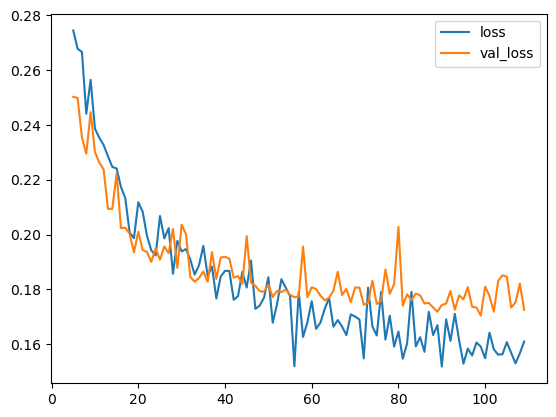

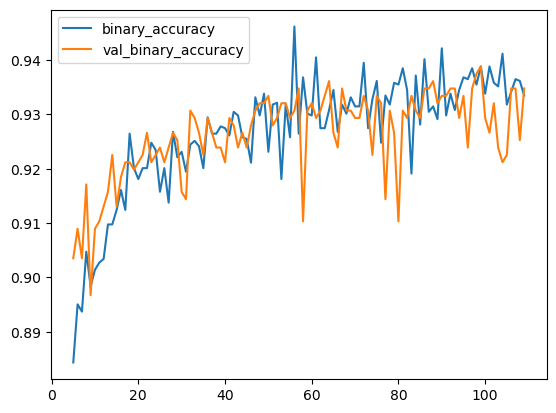

In [121]:
# Graph loss and binary accuracy graphs
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [122]:
# Evaluate samples using the model I've pretrained, saved, and loaded back
pretrained_cnn = keras.models.load_model('/kaggle/working/mobilenetv2best.hdf5')
eval_score = pretrained_cnn.evaluate(test_generator, steps = validation_steps)
# print loss score
print('Eval loss:',eval_score[0])
# print accuracy score
print('Eval accuracy:',eval_score[1])

23/23 [==============================] - 3s 83ms/step - loss: 0.1724 - binary_accuracy: 0.9389
Eval loss: 0.17238517105579376
Eval accuracy: 0.938858687877655


In [123]:
# Output classification report and confusion matrix
from sklearn.metrics import confusion_matrix , classification_report
# Get predicted and true classes for our report and matrix
y_pred = np.rint(pretrained_cnn.predict_generator(test_generator, steps = validation_steps)).astype(int)
y_test = [i[1] for i in test_list[0:-2]]
target_classes = ['No Tumor','Tumor']

classification_report(y_test , y_pred , output_dict = True
                      , target_names=target_classes)

{'No Tumor': {'precision': 0.9403341288782816,
  'recall': 0.9493975903614458,
  'f1-score': 0.9448441247002398,
  'support': 415},
 'Tumor': {'precision': 0.9337539432176656,
  'recall': 0.9221183800623053,
  'f1-score': 0.927899686520376,
  'support': 321},
 'accuracy': 0.9375,
 'macro avg': {'precision': 0.9370440360479736,
  'recall': 0.9357579852118756,
  'f1-score': 0.9363719056103079,
  'support': 736},
 'weighted avg': {'precision': 0.9374642381214098,
  'recall': 0.9375,
  'f1-score': 0.937453955331033,
  'support': 736}}

In [124]:
cm = confusion_matrix(y_test , y_pred ) 

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=False,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.set(font_scale=1.6)

    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

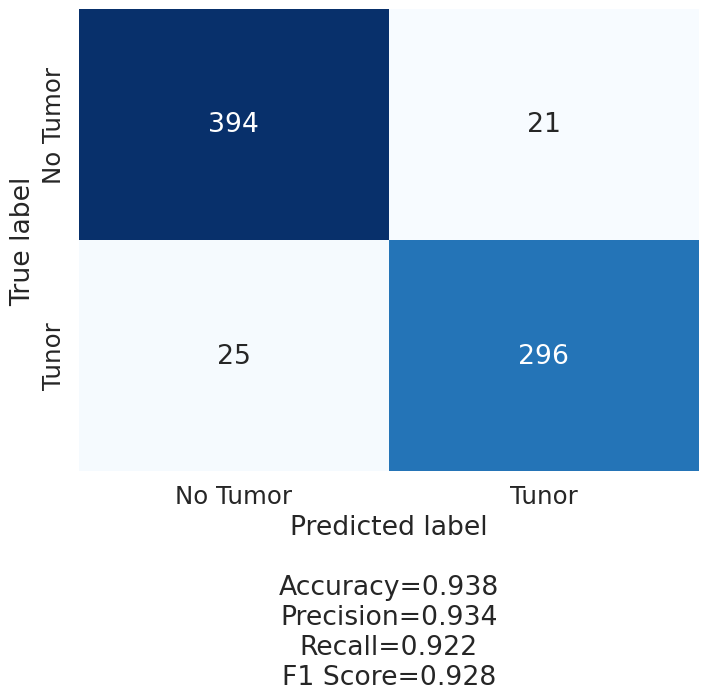

In [126]:
categories = ["No Tumor", "Tunor"]
make_confusion_matrix(cm, figsize=(8,6), cbar=False,categories=categories)

In [127]:
hist_csv_file = 'inceptionv3.csv'
with open(hist_csv_file, mode='w') as f:
    history_df.to_csv(f)